In [56]:
import sklearn
import csv
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


#https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python


In [57]:
df = pd.read_excel(r"C:\Users\x194356\Desktop\Intelligent_Data_Process\Final_results\Data_file.xlsx")
df.head()

,Name,Description,is linked to [Local Data Element] > Name
0,PR_ADDR_ID,Primary Address Id,Adresse
1,PR_SHIP_ADDR_ID,Primary Ship To Address Id,Adresse
2,COMMENTS,Comment Address,Adresse
3,COMMENTS,Short Comment,Adresse
4,COQAGE,CO - Age de l'assuré,Age de l'assuré


In [58]:
df=df.rename(columns = {'is linked to [Local Data Element] > Name':'Donnee_metier'})

In [59]:
len(df['Description'])

1029

In [60]:
len(df['Description'].value_counts())

284

In [61]:
len(df['Name'].value_counts())

161

In [62]:
df.head()

,Name,Description,Donnee_metier
0,PR_ADDR_ID,Primary Address Id,Adresse
1,PR_SHIP_ADDR_ID,Primary Ship To Address Id,Adresse
2,COMMENTS,Comment Address,Adresse
3,COMMENTS,Short Comment,Adresse
4,COQAGE,CO - Age de l'assuré,Age de l'assuré


# Pre-processing

In [63]:
proxy1=["N° Personne Sogessur","Numéro de personne","N° de personne,SI - N° Personne","SI - N° Personne Sogessur","N° Personne"]
for i in proxy1:
    df['Description'] =df['Description'].str.replace(i,"Numéro de client assuré")
    

In [64]:
proxy2=["CO - Coefficient Commercial","CO - Coefficient Commercial (Réduction Salariés)"]
for i in proxy2:
    df['Description'] =df['Description'].str.replace(i,"Ancienne réduction salariés (RED)")


In [65]:
proxy3=["SI - Date Saisie Montant","SI - Montant Provisions Restantes","Numéro de Police SOGESSUR","N° Devis","ALD - N° Police SOG","SI - Amount Incurred","CO - Acceptation FID O/N","SI - Montant Total Paiements","CO - CSP de l'assuré principal","SI - City of Accident"]
ch=["Date mouvement technique sinistre","Montant de la provision cédée restante","Numéro de contrat","Numéro de contrat","Numéro de contrat","Provision brute à la garantie du sinistre","Coefficient de fidélisation auto","Règlement net de recours à la garantie du sinistre","Catégorie socio-professionnelle de l'assuré","Ville du sinistre MRH"]
for i,j in zip(proxy3,ch):
    df['Description'] =df['Description'].str.replace(i,j)

In [66]:
Proxy4=["CO - Commercial Premium Amount","CO - Gross Premium","CO - Montat Prime HT"]
for i,j in zip(proxy3,ch):
    df['Description'] =df['Description'].str.replace(i,"Montant de la prime commerciale d'assurance hors taxes en devise de reporting")


In [67]:
df=df.apply(lambda x: x.astype(str).str.lower())

In [68]:
df['Description'] =df['Description'].str.replace('n°','numero')
df['Description']=df['Description'].str.replace("d'", '')
df['Description']=df['Description'].str.replace('\d+', '')
df['Description'] =df['Description'].str.replace('[^\w\s]',' ')

df['Donnee_metier']=df['Donnee_metier'].str.replace("d'", '')
df['Donnee_metier']=df['Donnee_metier'].str.replace('\d+', '')
df['Donnee_metier'] =df['Donnee_metier'].str.replace('[^\w\s]',' ')
#df['Donnee_metier'] =df['Donnee_metier'].str.replace(' +', ' ')


In [69]:
l1=['number','region','contract','name','customer','guarantee','address',"claim","closed","opened","status","HT","amendment","somme","cti","crmr","csdp","sdp","product"]
l2=['numero','pays','contrat','nom','client','garantie','adresse',"sinistre","cloture","ouverture","etat","Hors Taxes","avenant","montant","coefficient tarifaire individuel","crm recalculé","coefficient de surveillance du portefeuille","surveillance du portefeuille","produit"]
for i,j in zip(l1,l2):
    df['Description'] =df['Description'].str.replace(i,j)
    

In [70]:
#df to list
example_des=df.reset_index()['Description'].values.tolist()
example_m=df.reset_index()['Donnee_metier'].values.tolist()

In [71]:
#effacer les doublons 
example_m = list(dict.fromkeys(example_m))

In [72]:
#remove nan value from example_m:
example_m = [i for i in example_m if str(i) != 'nan']

In [73]:
len(example_m)

131

In [74]:
#concat les 2 listes
example=example_m+example_des

In [75]:
example

['adresse',
 'age de l assuré',
 'age de permis du conducteur principal',
 'age du conducteur principal',
 'age du véhicule assuré',
 'ancienne réduction salariés  red ',
 'année de construction du bien',
 'antécédents auto   cause sinistre non responsable',
 'antécédents auto   cause sinistre partiellement responsable',
 'antécédents auto   cause sinistre responsable',
 'antivol minimum exigé',
 'apprentissage anticipé de la conduite',
 'apprentissage anticipé de la conduite  enfant désigné ',
 'boîte de vitesse du véhicule',
 'canal de distribution du contrat',
 'canal de vente du contrat',
 'capital objets de valeur  mrh ',
 'capital objets usuels  mrh ',
 'carrosserie du véhicule',
 'catégorie socio professionnelle de l assuré',
 'classe de prix du véhicule',
 'classe de réparation du véhicule',
 'code bénéficiaire mouvement technique sinistre',
 'code cause sinistre',
 'code clause mrh',
 'code formule',
 'code formule sinistre',
 'code fractionnement contrat',
 'code garantie con

In [76]:
#dataframe de traitement
df = pd.DataFrame({'example':example})
print (df)

                                                example
0                                               adresse
1                                       age de l assuré
2                 age de permis du conducteur principal
3                           age du conducteur principal
4                                age du véhicule assuré
5                     ancienne réduction salariés  red 
6                         année de construction du bien
7     antécédents auto   cause sinistre non responsable
8     antécédents auto   cause sinistre partiellemen...
9         antécédents auto   cause sinistre responsable
10                                antivol minimum exigé
11                apprentissage anticipé de la conduite
12    apprentissage anticipé de la conduite  enfant ...
13                         boîte de vitesse du véhicule
14                     canal de distribution du contrat
15                            canal de vente du contrat
16                       capital objets de valeu

In [77]:
#spliter les phrases
from nltk.tokenize import word_tokenize
df['example']= [word_tokenize(entry) for entry in df['example']]

In [78]:
#enlever les stopwords (mot de liaison)
stopWords = set(stopwords.words('French'))
stopWords_ang = set(stopwords.words('English'))

In [79]:
l=["-","d","co","si"]
df['example']=df['example'].apply(lambda x: [item for item in x if item not in stopWords])
df['example']=df['example'].apply(lambda x: [item for item in x if item not in stopWords_ang])
df['example']=df['example'].apply(lambda x: [item for item in x if item not in l])

In [80]:
#stemming_frensh
from nltk.stem.snowball import FrenchStemmer

stemmer = FrenchStemmer()
stem_list=[]
for i in df['example']:
    stem_list.append ([stemmer.stem(word) for word in i])

In [81]:
stem_list

[['adress'],
 ['age', 'assur'],
 ['age', 'perm', 'conducteur', 'principal'],
 ['age', 'conducteur', 'principal'],
 ['age', 'véhicul', 'assur'],
 ['ancien', 'réduct', 'salari', 'red'],
 ['anné', 'construct', 'bien'],
 ['antécédent', 'auto', 'caus', 'sinistr', 'non', 'respons'],
 ['antécédent', 'auto', 'caus', 'sinistr', 'partiel', 'respons'],
 ['antécédent', 'auto', 'caus', 'sinistr', 'respons'],
 ['antivol', 'minimum', 'exig'],
 ['apprentissag', 'anticip', 'conduit'],
 ['apprentissag', 'anticip', 'conduit', 'enfant', 'désign'],
 ['boît', 'vitess', 'véhicul'],
 ['canal', 'distribu', 'contrat'],
 ['canal', 'vent', 'contrat'],
 ['capital', 'objet', 'valeur', 'mrh'],
 ['capital', 'objet', 'usuel', 'mrh'],
 ['carrosser', 'véhicul'],
 ['catégor', 'socio', 'professionnel', 'assur'],
 ['class', 'prix', 'véhicul'],
 ['class', 'répar', 'véhicul'],
 ['cod', 'bénéficiair', 'mouv', 'techniqu', 'sinistr'],
 ['cod', 'caus', 'sinistr'],
 ['cod', 'claus', 'mrh'],
 ['cod', 'formul'],
 ['cod', 'formul', 

In [82]:
#enlever les splits
import re
def untokenize(words):

    text = ' '.join(words) 
    return text.strip()


df['example']=[untokenize(entry) for entry in stem_list]


In [83]:
#Pour enlever les accents 
import unicodedata
def accent_remove(s):

    text = ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')) 
    return text

df['example']=[accent_remove(entry) for entry in df['example']]

In [84]:
#enlever les doubles espace entre les mots
df['example'] =df['example'].str.replace(' +', ' ')

In [85]:
df['example']

0                                                  adress
1                                               age assur
2                           age perm conducteur principal
3                                age conducteur principal
4                                       age vehicul assur
5                                ancien reduct salari red
6                                     anne construct bien
7                antecedent auto caus sinistr non respons
8            antecedent auto caus sinistr partiel respons
9                    antecedent auto caus sinistr respons
10                                   antivol minimum exig
11                           apprentissag anticip conduit
12             apprentissag anticip conduit enfant design
13                                    boit vitess vehicul
14                                 canal distribu contrat
15                                     canal vent contrat
16                               capital objet valeur mrh
17            

In [86]:
example=df.values.tolist()

In [87]:
flat_list = lambda l: [item for sublist in l for item in sublist]
flat_list(example)

['adress',
 'age assur',
 'age perm conducteur principal',
 'age conducteur principal',
 'age vehicul assur',
 'ancien reduct salari red',
 'anne construct bien',
 'antecedent auto caus sinistr non respons',
 'antecedent auto caus sinistr partiel respons',
 'antecedent auto caus sinistr respons',
 'antivol minimum exig',
 'apprentissag anticip conduit',
 'apprentissag anticip conduit enfant design',
 'boit vitess vehicul',
 'canal distribu contrat',
 'canal vent contrat',
 'capital objet valeur mrh',
 'capital objet usuel mrh',
 'carrosser vehicul',
 'categor socio professionnel assur',
 'class prix vehicul',
 'class repar vehicul',
 'cod beneficiair mouv techniqu sinistr',
 'cod caus sinistr',
 'cod claus mrh',
 'cod formul',
 'cod formul sinistr',
 'cod fraction contrat',
 'cod garant contrat',
 'cod garant sinistr',
 'cod inse adress travail auto',
 'cod inse bien assur',
 'cod inse lieu garag auto',
 'cod motif cti',
 'cod offre auto',
 'cod pay souscript contrat',
 'cod person',
 

In [88]:
example=[i.lstrip() for i in df['example']]

In [89]:
#TFIDF : pour l'encodage des données en donnant des poids pour chaque mots 
#Parametres : 
vectorizer = TfidfVectorizer(use_idf=True,smooth_idf=True,sublinear_tf=True)
dtm = vectorizer.fit_transform(example)
pd.DataFrame(dtm.toarray(),index=example,columns=vectorizer.get_feature_names())

,accident,accompagn,achat,acoefficient,adhes,adress,aec,affair,age,ald,...,usag,usuel,valeur,vehicul,vent,vill,vitess,voulu,written,zon
adress,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
age assur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.818001,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
age perm conducteur principal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.516710,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
age conducteur principal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.603521,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
age vehicul assur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.640668,0.0,...,0.0,0.000000,0.000000,0.621756,0.000000,0.000000,0.000000,0.0,0.0,0.000000
ancien reduct salari red,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
anne construct bien,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
antecedent auto caus sinistr non respons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
antecedent auto caus sinistr partiel respons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
antecedent auto caus sinistr respons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000


In [90]:
len(vectorizer.get_feature_names())

254

In [91]:
from scipy.sparse import csr_matrix
X_sparse = csr_matrix(dtm)
dtm = dtm.astype(float)
lsa = TruncatedSVD(min(X_sparse.shape)-1, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

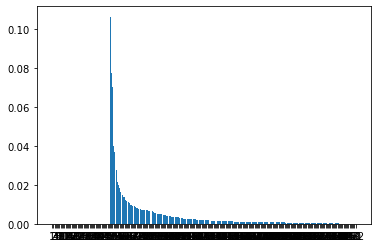

In [92]:
%matplotlib inline
import matplotlib.pyplot as plt
explained_variance=lsa.explained_variance_

def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(explained_variance))
    plt.bar(index, explained_variance)
    x=range(1,len(explained_variance))
    plt.xticks(index,x)
    plt.show()
plot_bar_x()  

In [93]:
#decomposition du matrice svd : 
U, s, Vh = np.linalg.svd(dtm_lsa, full_matrices=False)

print(U.shape, s.shape, Vh.shape)

(1160, 253) (253,) (253, 253)


In [94]:
pd.DataFrame(lsa.components_.round(5),columns = vectorizer.get_feature_names()).shape

(253, 254)

In [95]:
pd.DataFrame(dtm_lsa.round(5), index = example).shape

(1160, 253)

In [96]:
df = pd.read_excel(r"C:\Users\x194356\Desktop\Intelligent_Data_Process\Final_results\Data_file.xlsx")
df.head()

,Name,Description,is linked to [Local Data Element] > Name
0,PR_ADDR_ID,Primary Address Id,Adresse
1,PR_SHIP_ADDR_ID,Primary Ship To Address Id,Adresse
2,COMMENTS,Comment Address,Adresse
3,COMMENTS,Short Comment,Adresse
4,COQAGE,CO - Age de l'assuré,Age de l'assuré


In [97]:
df=df.rename(columns = {'is linked to [Local Data Element] > Name':'Donnee_metier'})


In [98]:
df.head()

,Name,Description,Donnee_metier
0,PR_ADDR_ID,Primary Address Id,Adresse
1,PR_SHIP_ADDR_ID,Primary Ship To Address Id,Adresse
2,COMMENTS,Comment Address,Adresse
3,COMMENTS,Short Comment,Adresse
4,COQAGE,CO - Age de l'assuré,Age de l'assuré


In [99]:
example_des_b=df.reset_index()['Description'].values.tolist()
len(example_des_b)

1029

In [100]:
#Label des Données bruts
example_m_num_b=df['Donnee_metier'].values.tolist()
example_m_num_b=list(dict.fromkeys(example_m_num_b))
example_m_num_b = [i for i in example_m_num_b if str(i) != 'nan']
len(example_m_num_b)

131

In [101]:
example_num_b=example_m_num_b+example_des_b
len(example_num_b)

1160

In [102]:
import numpy
# similarité LSA
similarity = np.asarray(numpy.asmatrix(dtm_lsa) * numpy.asmatrix(dtm_lsa).T)
CrossValid=pd.DataFrame(similarity,index=example_num_b,columns=example_num_b)

In [103]:
CrossValid.shape

(1160, 1160)

In [104]:
Matrice_M_Phy=CrossValid.iloc[len(example_m_num_b):, 0:len(example_m_num_b)]
Matrice_M_Phy_T=Matrice_M_Phy.T
Matrice_M_Phy_T.head()

,Primary Address Id,Primary Ship To Address Id,Comment Address,Short Comment,CO - Age de l'assuré,CO - Age Permis Conducteur,CO - Age Permis Conducteur,CO - Age conducteur,CO - Age Véhicule,CO - Age Véhicule,...,SI - Ville du sinistre,SI - Ville du sinistre,SI - Ville du sinistre,SI - Ville du sinistre,SI - Ville du sinistre,SI - Ville du sinistre,SI - Ville du sinistre,CO - Ancienne Zone Locale,CO - Zone Locale,CO - Zone Locale
Adresse,5.444830e-01,4.467353e-01,6.372887e-01,-3.102996e-17,-1.141359e-16,1.407049e-16,1.407049e-16,6.117970e-17,7.438094e-17,7.438094e-17,...,2.388530e-16,2.388530e-16,2.388530e-16,2.388530e-16,2.388530e-16,2.388530e-16,2.388530e-16,-5.956722e-17,-1.856228e-16,-1.856228e-16
Age de l'assuré,-5.534377e-17,-6.810585e-17,-1.284654e-16,1.273265e-17,1.000000e+00,4.808949e-01,4.808949e-01,5.944749e-01,5.870132e-01,5.870132e-01,...,-1.912651e-16,-1.912651e-16,-1.912651e-16,-1.912651e-16,-1.912651e-16,-1.912651e-16,-1.912651e-16,1.213026e-16,4.123521e-17,4.123521e-17
Age de permis du conducteur principal,1.638478e-16,1.273125e-16,1.056871e-16,-1.268203e-16,4.226696e-01,8.789231e-01,8.789231e-01,7.109965e-01,3.708014e-01,3.708014e-01,...,1.365199e-16,1.365199e-16,1.365199e-16,1.365199e-16,1.365199e-16,1.365199e-16,1.365199e-16,1.708227e-16,5.415057e-17,5.415057e-17
Age du conducteur principal,1.077245e-16,1.613192e-16,-4.012103e-17,-1.104389e-16,4.936805e-01,6.717831e-01,6.717831e-01,8.304480e-01,4.330981e-01,4.330981e-01,...,-3.992290e-17,-3.992290e-17,-3.992290e-17,-3.992290e-17,-3.992290e-17,-3.992290e-17,-3.992290e-17,2.014403e-16,4.932302e-17,4.932302e-17
Age du véhicule assuré,-1.883278e-17,-1.516561e-17,-4.183138e-18,9.740271e-17,7.832114e-01,3.766424e-01,3.766424e-01,4.655995e-01,8.927681e-01,8.927681e-01,...,-2.881330e-16,-2.881330e-16,-2.881330e-16,-2.881330e-16,-2.881330e-16,-2.881330e-16,-2.881330e-16,1.048815e-16,-1.049823e-17,-1.049823e-17


In [105]:
#Max_output_FINAL

path=r'C:\Users\x194356\Desktop\Intelligent_Data_Process\Final_results'
with open(path+'\output.csv', mode='w',newline='') as file:
    writer = csv.writer(file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(["Physical data","Physical data Description","Business Data","Correlation score"])
    for index, row in Matrice_M_Phy.iterrows():  
        writer.writerow([df['Name'][df['Description']==index].unique(),index,row.idxmax(),round(row.loc[row.idxmax()],4)])


# Perf 

In [115]:
#Ratio_output
path=r'C:\Users\x194356\Desktop\Intelligent_Data_Process\Final_results'
with open(path+'\output_all.csv', mode='w',newline='') as file:
    writer = csv.writer(file, delimiter=';', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(["Business_data_pred","Phy_data_pred","Desc_phy_data_pred","Corr_score_pred"])
    for index, row in Matrice_M_Phy.iterrows():  
        for j,i in zip((row.loc[(row>-1)]),(row.loc[(row>-1)].index)):
            writer.writerow([index,df['Name'][df['Description']==index].unique(),i,round(j,4)])
            #writer.writerow([index,df['Name'][df['Description']==i].unique(),i,(j/max(row))))])

        

In [116]:
df_perf = pd.read_excel(r"C:\Users\x194356\Desktop\Intelligent_Data_Process\Final_results\output_all.xlsx")
df_perf.head()

,Business_data_pred,Phy_data_pred,Desc_phy_data_pred,Corr_score_pred,Business_data_True,y_true
0,Primary Address Id,['PR_ADDR_ID'],Adresse,0.5445,Adresse,1
1,Primary Address Id,['PR_ADDR_ID'],Age de l'assuré,-0.0000,Adresse,0
2,Primary Address Id,['PR_ADDR_ID'],Age de permis du conducteur principal,0.0000,Adresse,0
3,Primary Address Id,['PR_ADDR_ID'],Age du conducteur principal,0.0000,Adresse,0
4,Primary Address Id,['PR_ADDR_ID'],Age du véhicule assuré,-0.0000,Adresse,0


In [117]:
df_class= pd.DataFrame(columns=['Seuil', 'TP', 'TN','FP','FN'])
for i in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]: 
    df_perf["pred'{}'".format(i)]=df_perf['Corr_score_pred']
    df_perf["pred'{}'".format(i)]=[0 if x <i else 1 for x in df_perf["pred'{}'".format(i)]]
    tn, fp, fn, tp = confusion_matrix(df_perf.y_true, df_perf["pred'{}'".format(i)]).ravel()
    df_class=df_class.append({'Seuil':i,'TP': tp,'TN' :tn,'FP':fp,'FN' : fn}, ignore_index=True)

In [118]:
df_class

,Seuil,TP,TN,FP,FN
0,0,1029,0,133770,0
1,0.1,1004,117942,15828,25
2,0.2,982,126685,7085,47
3,0.3,958,130169,3601,71
4,0.4,938,133083,687,91
5,0.5,914,133449,321,115
6,0.6,875,133600,170,154
7,0.7,841,133645,125,188
8,0.8,751,133733,37,278
9,0.9,697,133769,1,332


In [119]:
df_report=pd.DataFrame(columns=['Score', 'Recall', 'Precision','F1'])
for i in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]:
    df_report=df_report.append({'Score':i,'Recall':recall_score(df_perf.y_true, df_perf["pred'{}'".format(i)]),
                                'Precision':precision_score(df_perf.y_true, df_perf["pred'{}'".format(i)]),
                                'F1':f1_score(df_perf.y_true, df_perf["pred'{}'".format(i)]),
                                'TPR':recall_score(df_perf.y_true, df_perf["pred'{}'".format(i)]),
                                'FPR':(df_class.FP[i*10]/(df_class.FP[i*10]+df_class.TN[i*10]))},ignore_index=True)

In [120]:
df_report

,Score,Recall,Precision,F1,FPR,TPR
0,0.0,1.000000,0.007634,0.015152,1.000000,1.000000
1,0.1,0.975705,0.059648,0.112424,0.118322,0.975705
2,0.2,0.954325,0.121731,0.215919,0.052964,0.954325
3,0.3,0.931001,0.210134,0.342878,0.026919,0.931001
4,0.4,0.911565,0.577231,0.706858,0.005136,0.911565
5,0.5,0.888241,0.740081,0.807420,0.002400,0.888241
6,0.6,0.850340,0.837321,0.843780,0.001271,0.850340
7,0.7,0.817298,0.870600,0.843108,0.000934,0.817298
8,0.8,0.729835,0.953046,0.826637,0.000277,0.729835
9,0.9,0.677357,0.998567,0.807180,0.000007,0.677357


In [121]:
%pylab
for i,j in zip([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],['b','g','r','c','m','y','k','olive', 'gray', 'pink']):
    fpr, tpr, threshold = metrics.roc_curve(df_perf.y_true, df_perf["pred'{}'".format(i)])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, '{}'.format(j), label = "AUC = %0.3f" % roc_auc)


figsize(12, 8)
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [125]:
%pylab
figsize(10, 10)
plt.style.use('seaborn-dark-palette')
Score = [str(t) for t in df_report['Score']]
plt.plot(df_report['FPR'], df_report['TPR'], 'bo-', label = 'LSA model');
plt.plot(list(np.linspace(0, 1, num = 10)), list(np.linspace(0, 1, num = 10)), 'ro--', label = 'classifier');
for x, y, s in zip(df_report['FPR'], df_report['TPR'], Score):
    plt.text(x - 0.04,y + 0.02, s, fontdict={'size': 14});

plt.legend(prop={'size':14})
plt.ylabel('True Positive Rate', size = 16); plt.xlabel('False Positive Rate', size = 16);
plt.title('Receiver Operating Characteristic Curve', size = 20);

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib
